<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/cci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

# Disable warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import norm
from scipy.optimize import minimize

# Config display
%config InlineBackend.figure_format = 'retina'

In [3]:
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/cci.csv')
df.columns = df.columns.str.replace(' ', '') #Remove blank space

# Monthly transition matrix
totalMonth = df.groupby(['Month', 'Aging'], as_index = False, sort = False)['N'].sum().rename(columns = {'N': 'Total'})
df = pd.merge(df, totalMonth, on = ['Month', 'Aging'], how = 'left') #Avoid missing in some month
df['TransitionRate'] = df['N'] / df['Total']

# Average transition matrix
averageMatrix = df.groupby(['Aging', 'Aging12'], as_index = False)['N'].sum()
total = df.groupby(['Aging'], as_index = False)['N'].sum().rename(columns = {'N': 'Total'})
averageMatrix = pd.merge(averageMatrix, total, on = ['Aging'], how = 'left')
averageMatrix['TransitionRate'] = averageMatrix['N'] / averageMatrix['Total']

# Upper threshold
averageMatrix['CumDefault'] = averageMatrix.groupby(['Aging'])['TransitionRate'].cumsum()
averageMatrix['Survive'] = 1 - averageMatrix['CumDefault']
averageMatrix['Survive1'] = averageMatrix.groupby(['Aging'], sort = False)['Survive'].shift(1).fillna(0)
averageMatrix['Upper'] = norm.ppf(averageMatrix['Survive1'])

In [4]:
# Convert to numpy array
# N Array
nArray = df[df['Aging'] != 4] #Drop default at observation
nArray = nArray.groupby(['Month', 'Aging'], as_index = False)['N'].sum()
nArray = nArray['N'].to_numpy()
nArray = np.repeat(nArray, df['Aging'].max() + 1)
nArray = nArray.reshape(np.unique(df['Month']).shape[0], -1)

# Monthly array
monthlyArray = df[df['Aging'] != 4] #Drop default at observation
monthlyArray = pd.pivot_table(monthlyArray,
                              values = 'TransitionRate',
                              index = ['Month', 'Aging'],
                              columns = ['Aging12']).fillna(0) #Missing observation in month
monthlyArray = monthlyArray.to_numpy()
monthlyArray = monthlyArray.reshape(np.unique(df['Month']).shape[0], -1)

# Upper array
upperArray = averageMatrix[averageMatrix['Aging'] != 4] #Drop default at observation
upperArray = pd.pivot_table(upperArray,
                            values = 'Upper',
                            index = ['Aging'],
                            columns = ['Aging12']).fillna(0) #Missing observation
upperArray = upperArray.to_numpy()

In [5]:
# Credit cycle index (CCI)
# Define CCI Function
def creditCycleIndex(x):
  monthlyFitted = []
  
  for i in range(x.shape[0] - 1):
    fittedUpper = (upperArray - (np.sqrt(x[-1]) * x[i])) / np.sqrt(1 - x[-1])
    monthlyFitted.append(fittedUpper)
      
  monthlyFitted = np.vstack(monthlyFitted)

  # Fitted matrix
  cdfMonthly = [norm.cdf(monthlyFitted[0:, i]) for i in range(1, 5)] #Cumulative matrix
  
  fittedMatrix = np.stack((1 - cdfMonthly[0],
                           cdfMonthly[0] - cdfMonthly[1],
                           cdfMonthly[1] - cdfMonthly[2],
                           cdfMonthly[2] - cdfMonthly[3],
                           cdfMonthly[3]), axis = 1)

  fittedMatrix = fittedMatrix.reshape(x.shape[0] - 1, -1)
  
  # Error matrix
  errorMatrix = nArray * ((monthlyArray - fittedMatrix) ** 2) / (fittedMatrix * (1 - fittedMatrix))
  error = np.sum(errorMatrix) 
  return error

# Define minimize error
def findCCI(x):
  return creditCycleIndex(x)

# Define constraints
def constraint(x):
  return np.std(x[:-1]) - 1

In [6]:
# Initial guess
x0 = np.random.randn(monthlyArray.shape[0]) #Guess CCI
rho0 = 0.0001 #Set Rho close to 0
init = np.hstack((x0, rho0))

# Constraints
constraints = {'type': 'eq', 'fun': constraint}

# Set option for iteration
options = {'maxiter': 10000, 'disp': True} #Increase number of iteration

In [7]:
# Finding CCI
CCIOpt = minimize(findCCI, init, constraints = constraints, options = options)
CCIOpt

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3354.4796158453773
            Iterations: 108
            Function evaluations: 4774
            Gradient evaluations: 108


     fun: 3354.4796158453773
     jac: array([ 0.06829834,  0.0123291 ,  0.05096436,  0.050354  ,  0.07104492,
        0.06393433,  0.09631348,  0.0715332 ,  0.0368042 ,  0.02963257,
        0.04269409,  0.05484009,  0.01855469,  0.01577759,  0.02191162,
       -0.00524902,  0.00073242, -0.00994873, -0.02490234, -0.02908325,
       -0.03762817, -0.01559448, -0.00469971, -0.00128174, -0.00396729,
       -0.01306152, -0.02172852, -0.0256958 , -0.02685547, -0.02880859,
       -0.02835083, -0.03488159, -0.05413818, -0.04870605, -0.04815674,
       -0.03833008, -0.04736328, -0.05340576, -0.0501709 , -0.05053711,
       -0.35327148])
 message: 'Optimization terminated successfully.'
    nfev: 4774
     nit: 108
    njev: 108
  status: 0
 success: True
       x: array([ 1.86818616,  0.53705285,  1.455843  ,  1.42953698,  1.91792209,
        1.78166168,  2.54290907,  1.92507028,  1.09951023,  0.9121397 ,
        1.24342426,  1.54573296,  0.68822395,  0.59603726,  0.77086116,
        0.11453715

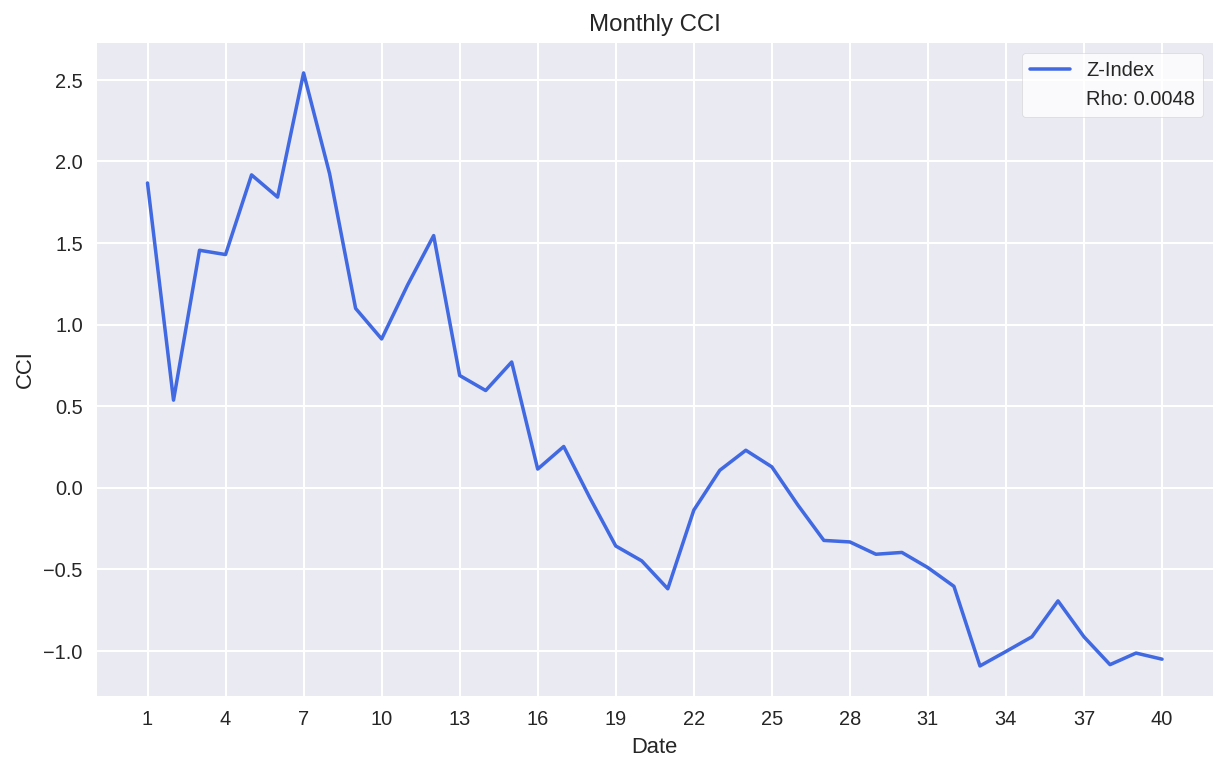

In [8]:
# Results
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Monthly CCI')
  plt.xlabel('Date')
  plt.ylabel('CCI')
  plt.plot(np.arange(1, CCIOpt.x[:-1].shape[0] + 1),
           CCIOpt.x[:-1], c = 'royalblue', label = 'Z-Index')
  plt.plot([], [], ' ', label = f'Rho: {CCIOpt.x[-1]:.4f}')
  plt.xticks(np.arange(1, CCIOpt.x[:-1].shape[0] + 1, 3))
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()